# Online Convex Optimization

Данные будем брать из этого датасета:
https://archive.ics.uci.edu/ml/datasets/spambase

In [43]:
# подключение необходимых библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
%matplotlib inline

In [73]:
spam_data = pd.read_csv('spambase.data', header=None)

d = 55
spam_data.columns = np.arange(0, 58)
print(d)
spam_data.head()

55


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Заметим, что в данном датасете сначала идут те сообщения, которые являются спамом, а потом - те, которые не являются. Это может негативно сказаться на качестве работы алгоритмов. Поэтому сделаем `shuffle` строк датасета при помощи функции `pandas.sample`.

In [81]:
spam_data = spam_data.sample(frac=1)
spad_data = pd.DataFrame(spam_data.values, columns=spam_data.columns)
spam_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
1895,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.14,0.00,...,0.058,0.156,0.000,0.000,0.000,0.000,1.687,24,496,0
4178,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.86,...,0.000,0.321,0.000,0.214,0.000,0.000,3.956,51,91,0
1514,0.00,0.00,0.00,0.0,0.00,1.36,0.00,0.00,1.36,0.00,...,0.000,0.000,0.000,1.777,0.222,0.000,9.727,63,107,1
3204,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.091,0.000,0.045,0.000,0.000,2.333,15,175,0
25,0.05,0.07,0.10,0.0,0.76,0.05,0.15,0.02,0.55,0.00,...,0.042,0.101,0.016,0.250,0.046,0.059,2.565,66,2258,1
1740,0.00,0.00,0.00,0.0,0.65,0.00,0.65,0.00,0.00,0.00,...,0.000,0.000,0.000,1.765,0.000,0.000,3.025,21,118,1
2382,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.188,0.376,0.000,0.000,2.310,15,67,0
1337,0.00,0.00,0.00,0.0,0.00,0.00,1.15,0.00,0.00,0.00,...,0.000,0.000,0.000,0.486,0.347,0.000,1.608,6,74,1
1764,0.96,0.00,0.48,0.0,0.00,0.96,0.00,0.00,0.48,0.00,...,0.000,0.818,0.000,0.175,0.467,0.116,9.560,259,717,1
1833,0.00,0.63,0.00,0.0,1.27,0.00,0.00,0.00,0.00,0.00,...,0.000,0.218,0.000,0.000,0.000,0.000,2.215,22,113,0


Для дальнейшего применения алгоритмов разобьём данные на значения признаков и столбец целевой переменной.

In [82]:
X = spam_data[np.arange(d)].values
y = spam_data[57].values

### Online Gradient Descent

Для начала, чтобы убедиться в адекватности построенной модели, применим online градиентный спуск.
Запустим его на разных начальных приближениях.

**Замечание.**

Для получения значений `regret`ов был использован пакет для выпуклой оптимизации `cvxpy`, который получает ответ достаточно медленно. По этой причине я считал эти значения не на всех итерациях алгоритма.

Чтобы не считать значения `regret`, можно не передавать 3 параметр в функцию `online_gradient_descent`.

In [94]:
R = 1.0
G = 0.1
D = 2.0 * R

M = 100.0*R

def proection(x):
    if np.linalg.norm(x) <= R:
        return x
    return x / np.linalg.norm(x) * R

def grad(x, w):
    return (np.dot(x, w) + M) / (4.0*M**2) * w

def calc_opt_value(x_list, y_list):
    w = cvx.Variable(d)
    #print(x_list)
    #print(y_list)
    prob = cvx.Problem(cvx.Minimize(cvx.sum_squares(y_list - (x_list*w + M) / (2*M))), 
                       [cvx.sum_squares(w) <= R**2])

    result = prob.solve(solver=cvx.SCS, verbose=False, eps=0.01)
    return result

def calc_regret(cur_sum, x_list, y_list):
    return cur_sum - calc_opt_value(x_list, y_list)

def online_gradient_descent(x0, T, regrets=None):
    x = x0
    t = 1
    cur_sum = 0
    x_list = []

    while t <= T:
        alpha = D / (G * float(t)**0.5)
        new_x = proection(x - alpha * grad(x, X[t - 1]))
        
        x = new_x
        x_list.append(x)
        cur_sum += (y[t - 1] - (np.dot(X[t - 1], x) + M) / (2*M))**2
        if not (regrets is None) and ((t == T) or (t % 500 == 0)):
            regrets.append((t, calc_regret(cur_sum, np.array(x_list), y[:t])))
        t += 1
    return x
    
def try_online_gd(x0):
    regrets = []
    a = online_gradient_descent(x0, len(spam_data), regrets)
    dots = np.dot(X, a)
    predict = (np.sign(dots) + 1.0) / 2
    regrets = np.array(regrets)

    success = len(predict[predict == y])
    print('accuracy: ', float(success) / len(spam_data))
    print('regrets: ', regrets[:, 1])
    return (regrets[:, 0], regrets[:, 1])
    
regret_matr = []
regret_matr.append(try_online_gd(np.zeros(d)))
regret_matr.append(try_online_gd(np.ones(d) * R / (float(d)**0.5)))
regret_matr.append(try_online_gd(np.hstack(([R], np.zeros(d - 1)))))

('accuracy: ', 0.6059552271245382)
('regrets: ', array([ 28.75337572,  30.60615216,  38.12708182,  43.30863986,
        53.53080341,  62.36321683,  90.01914729,  99.00194448,
       122.36490645, 123.24289961]))
('accuracy: ', 0.6059552271245382)
('regrets: ', array([ 28.70571277,  30.60130157,  38.20190106,  43.41069412,
        53.67501263,  62.5428138 ,  90.22482272,  99.22245738,
       122.57537044, 123.46732583]))
('accuracy: ', 0.6059552271245382)
('regrets: ', array([ 28.70784156,  30.57691117,  38.14469556,  43.33327929,
        53.56339524,  62.40981645,  90.08434052,  99.10052064,
       122.44439268, 123.3222905 ]))


Построим графики посчитанных значений $regret$ в каждом случае.

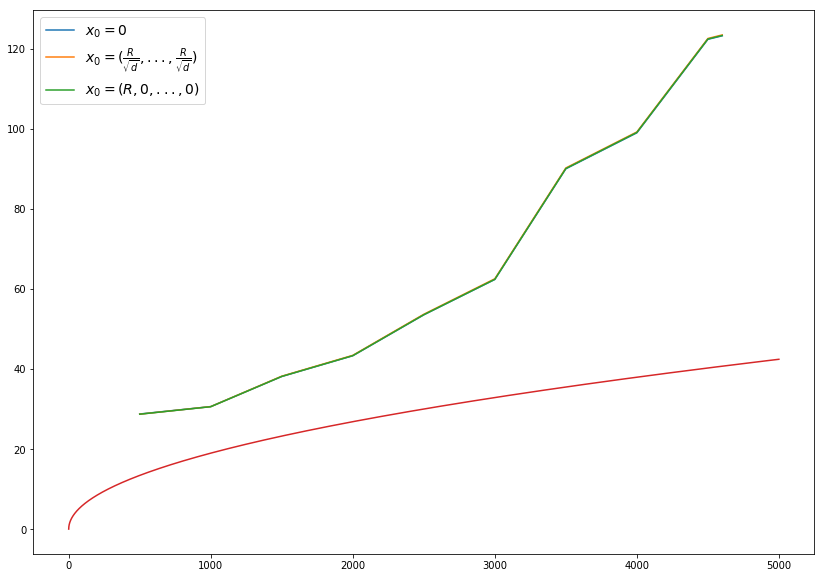

In [108]:
def plot_gd_regrets(regrets, labels=['$x_0=0$', 
                                  '$x_0=(\\frac{R}{\\sqrt{d}}, ..., \\frac{R}{\\sqrt{d}})$',
                                  '$x_0=(R, 0, ..., 0)$']):
    plt.figure(figsize=(14, 10))
    for (regret, label) in zip(regrets, labels):
        plt.plot(regret[0], regret[1], label=label)
        
    grid = np.linspace(0, 5000, 100000)
    plt.plot(grid, 3.0*D*G*(grid**0.5))
        
    plt.legend(fontsize=14)
    plt.show()

plot_gd_regrets(np.array(regret_matr))

**Вывод.**

1) Как можно увидеть, от начального приближения точность алгоритма не зависит. И графики зависимости значения $regret$ от номера итерации получились при всех трёх рассмотренных начальных приближениях похожими.

2) Теоретические оценки для верхней границы значений $regret$ оказались выполнены, что показывает достаточно.

0.605955227125


### Online Stochastic Gradient Descent